In [316]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from PhysPropWater import rho
from sklearn.preprocessing import MinMaxScaler
import pickle

In [317]:
torch.manual_seed(42)
np.random.seed(42)
scaler = MinMaxScaler()

In [318]:
with open('reacdata.pc','rb') as f:
    data = pickle.load(f)

# Stacking the two arrays column-wise and converting them to a torch tensor
combined_data = np.column_stack((data['pH'], data['ratio S/A']))
X = torch.tensor(combined_data, dtype=torch.float32)
X1 = torch.tensor(data['pH'], dtype=torch.float32).view(-1, 1)
X2 = torch.tensor(data['ratio S/A'], dtype=torch.float32).view(-1, 1)
y = torch.tensor(data['yield'], dtype=torch.float32).view(-1, 1)
y_scaled = scaler.fit_transform(y)
y_scaled_tensor = torch.tensor(y_scaled, dtype=torch.float32)

y_bin = torch.zeros_like(y)
y_bin[y > 0.45] = 1

X_scaled = scaler.fit_transform(X)
X_scaled_tensor = torch.tensor(X_scaled, dtype=torch.float32)

In [319]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(2, 20),
            nn.ReLU(),
            nn.Linear(20, 50),
            nn.ReLU(),
            nn.Linear(50, 20),
            nn.ReLU(),
            nn.Linear(20, 1),
            #nn.Sigmoid()    
        )
        
    def forward(self, x):
        return self.model(x)

In [320]:
model = Model()
#loss_fn = nn.BCELoss()
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters())

In [321]:
# Train the model

EPOCS = 5000
losses = []  # List to store loss values for each epoch

print("Starting training...")

for epoch in range(EPOCS):
    optimizer.zero_grad()
    y_pred = model(X_scaled_tensor)
    loss = loss_fn(y_pred, y)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
    
    # Print the loss every 500 epochs to monitor training
    if epoch % 500 == 0:
        print(f"Epoch {epoch}/{EPOCS} - Loss: {loss.item()}")
    if epoch > 300:
        diff = losses[-300] - losses[-1]
        if diff > 0 and diff <= 5e-5:
            print(f"Model converged after {epoch} epochs\nLoss: {loss.item()}\nDerivative: {losses[-300] - losses[-1] / len(losses[-300:-1])}")
            break
    

print("Training completed.")

Starting training...
Epoch 0/5000 - Loss: 0.10676130652427673
Epoch 500/5000 - Loss: 0.0001608517050044611
Model converged after 889 epochs
Loss: 5.762504952144809e-05
Derivative: 0.00010721746331186308
Training completed.


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Ncorrect: 113
Nsamples: 200
Accuracy: 0.5649999976158142


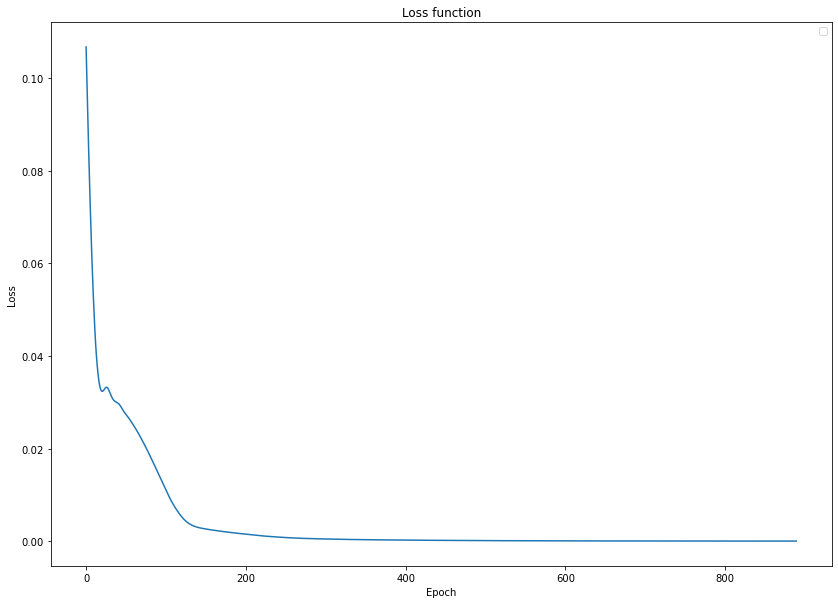

In [322]:
y_pred = model(X)
#print(y_pred)
y_bin_pred = torch.zeros_like(y_pred)
y_bin_pred[y_pred > 0.5] = 1
#print(y_bin_pred)
Ncorrect = torch.sum(y_bin_pred == y_bin)
Nsamples = y_bin.shape[0]
acc = Ncorrect/Nsamples
print(f"Ncorrect: {Ncorrect}")
print(f"Nsamples: {Nsamples}")
print(f"Accuracy: {acc}")

# Plot the loss function

fig, ax = plt.subplots(figsize=(14, 10))

#loss function
ax.plot(losses)
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.set_title("Loss function")
#ax.vlines(epoch, losses[-1], max(losses), color='red', label='Convergence')
ax.legend()

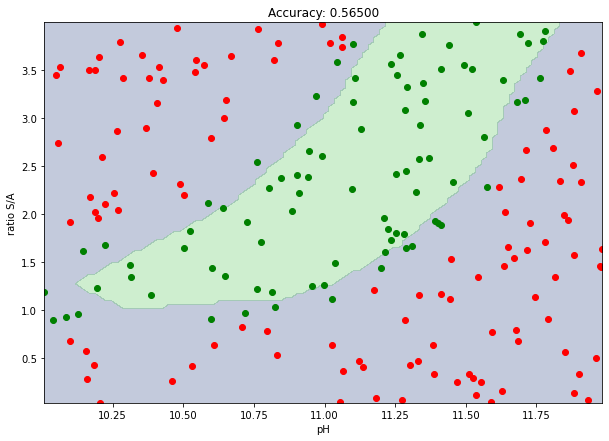

In [323]:
plt.figure(figsize=(10, 7))

for i in range(len(X1)):
    if y_bin[i]: # 1
        plt.plot(X1[i], X2[i], 'go')
    else: # 0
        plt.plot(X1[i], X2[i], 'ro')

# Create finely gridded x1 and x2
Ngrid = 100
x1_fine = np.linspace(X1.min().item(), X1.max().item(), Ngrid)
x2_fine = np.linspace(X2.min().item(), X2.max().item(), Ngrid)
X1_fine, X2_fine = np.meshgrid(x1_fine, x2_fine)
# Combine them to a matrix instead for speed
X_fine = np.vstack((X1_fine.flatten(),X2_fine.flatten())).T

X_fine_scaled = scaler.transform(X_fine)  # Use transform, not fit_transform
X_fine_scaled_tensor = torch.tensor(X_fine_scaled, dtype=torch.float32)
y_fine = model(X_fine_scaled_tensor)
# Make it binary
y_fine_binary = (y_fine.detach().numpy() > 0.5).astype(int)
# Reshape it as a matrix
Y_binary = y_fine_binary.reshape((Ngrid, Ngrid))

plt.contourf(X1_fine, X2_fine, Y_binary, levels=[0, 0.5, 1], alpha=0.3) # Use contourf with alpha for better visualization
plt.xlabel('pH')
plt.ylabel('ratio S/A')
plt.title(f'Accuracy: {acc:.5f}')
plt.show()